In [13]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from IPython.display import display, HTML
import subprocess
import pdfkit as pdf

#HTML(df.to_html())
#display(df)

hpi_red = '#b00639'
hpi_blue = '#007a9e'

def data_frame_to_pdf(df):
    filename = 'out.tex'
    pdffile = 'out.pdf'
    outname = 'out.png'

    template = r'''\documentclass[preview]{{standalone}}
    \usepackage{{booktabs}}
    \begin{{document}}
    {}
    \end{{document}}
    '''

    with open(filename, 'w') as f:
        f.write(template.format(df.to_latex()))

    subprocess.call(['pdflatex', filename])
    subprocess.call(['convert', '-density', '300', pdffile, '-quality', '90', outname])
    
def data_frame_to_tex(df, filename):
    with open(filename, 'w') as f:
        f.write(df.to_latex())

def get_column_names(benchmark): 
    table_info = json.load(open(benchmark + '_results.csv.json','r'))
    #print(json.dumps(table_info, indent=2, sort_keys=False))
    column_names = []
    for column in table_info["columns"]:
        column_names.append(column["name"])
    return column_names

def get_results(benchmark):
    return pd.read_csv(benchmark + '_results.csv', header=None, names=get_column_names(benchmark))

def percent(x, pos):
    'The two args are the value and tick position'
    return ('%i' % (x * 100)) + "%"

# Columns: sample_size, distinct_values, variance, remainder_size, value, actual_count, filter_count
def select(data, value_count, distinct_values, data_distribution, quotient_size, remainder_size):
    return data[(data.value_count == value_count) &
                (data.distinct_values == distinct_values) &
                (data.data == data_distribution) & 
                (data.remainder_size == remainder_size) &
                (data.quotient_size == quotient_size)]

def get_mean_squared_error(errors, probabilities):
    mse = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        mse += probability * error * error
        
    return mse

def get_mean_error(errors, probabilities):
    me = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        me += probability * error
        
    return me

def misestimation_evaluation(quotient_size, remainder_size, data_distribution, distinct_values):
    #percent_formatter = FuncFormatter(percent)
    #ax.yaxis.set_major_formatter(percent_formatter)
    
    #Prepare the data
    data_name = data_distribution + str(distinct_values)
    data = get_results("cardinality_misestimation_" + data_name)
    value_count = data["value_count"].iloc[0]
    selection = select(data, value_count, distinct_values, data_name, quotient_size, remainder_size)
    if len(selection) == 0:
        return
    sample_size = selection["sample_size"].iloc[0]
    over_estimations = selection["over_estimation"]
    probabilities = selection["occurrences"].apply(lambda x: x / sample_size)
    biggest_overestimation = max(over_estimations)
    x_data = range(0, biggest_overestimation + 1)
    y_data = np.zeros(biggest_overestimation + 1)
    for i in range(0, len(over_estimations)):
        y_data[over_estimations.iloc[i]] = probabilities.iloc[i]
    one_off_probability = y_data[1]
    correct_probability = y_data[0]
    mean_error = get_mean_error(over_estimations, probabilities)
    mean_square_error = get_mean_squared_error(over_estimations, probabilities)
    filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
    filter_size_bytes = filter_size_bits / 8
    bits_per_value = filter_size_bits / value_count
    column_size = value_count * 2
    
    # Print some Information
    print("Sample Size: " + str(sample_size))
    print("One off error probability: " + str(one_off_probability))
    print("Mean Error: " + str(mean_error))
    print("Mean Squared Error: " + str(mean_square_error))
    print("Correct " + str(correct_probability * 100) + "%" + " of the time")
    print("Filter Size [kB]: " + str(filter_size_bytes / 1000))
    print("Bits per Value: " + str(bits_per_value))
    print("Column Size [kB](uint16_t): "  + str(column_size / 1000))
    
    # Configure the plot
    title = "Overcount probabilites"
    subtitle = "Value Count: " + str(value_count) \
                + ", Distinct Values: " + str(distinct_values) + ", Data: " + data_distribution + '\n'\
                + "Quotient Size: " + str(quotient_size) + ", Remainder Size: " + str(remainder_size)
    fig, ax = plt.subplots()
    plt.title(title)# + '\n' + subtitle)
    #.apply(lambda x: x * 100)
    plt.plot(x_data[1:100], np.array(y_data[1:100]) * 100, color=hpi_red, label="filter counts")
    plt.ylabel('Probability [%]')
    plt.xlabel('Overcount')
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=1)
    ax.yaxis.grid()
    ax.xaxis.grid()
    
    # Save Output
    file_name = (title + '_' + subtitle).replace(" ", "_").replace(":", "_").replace(".","_") \
                                        .replace(",","_").replace("\n","_").replace("__", "_")
    plt.savefig('plots/cardinality_estimation/{}.pgf'.format(file_name))
    plt.savefig('plots/cardinality_estimation/{}.pdf'.format(file_name))
    
    #Render
    plt.show()

def evaluate(quotient_size, remainder_size, data_distribution, distinct_values):
    data_name = data_distribution + str(distinct_values)
    data = get_results("filter_cardinality_estimation_" + data_name)
    value_count = data["value_count"].iloc[0]
    selection = select(data, value_count, distinct_values, data_name, quotient_size, remainder_size)
    if len(selection) == 0:
        return
    
    title = "Filter Counts Vs. Actual Counts"
    subtitle = "Value Count: " + str(value_count) \
                + ", Distinct Values: " + str(distinct_values) + ", Data: " + data_distribution + '\n' \
                + "Quotient Size: " + str(quotient_size) + ", Remainder Size: " + str(remainder_size)
            
    fig, ax = plt.subplots()
    plt.title(title)# + '\n' + subtitle)
    plt.plot(selection["value"], selection["filter_count"], color=hpi_red, label="Filter Counts")
    plt.plot(selection["value"], selection["actual_count"], color=hpi_blue, label="Actual Counts")
    plt.legend(loc='upper left')
    plt.ylabel('Value Count')
    plt.xlabel('Distinct Values')
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)
    ax.set_xlim(xmax=distinct_values)
    
    file_name = (title + '_' + subtitle).replace(" ", "_").replace(":", "_").replace(".","_") \
                    .replace(",","_").replace("\n","_").replace("__", "_")
    plt.savefig('plots/cardinality_estimation/{}.pgf'.format(file_name))
    plt.savefig('plots/cardinality_estimation/{}.pdf'.format(file_name))
    plt.show()
    
def filter_comparison_table(quotient_sizes, remainder_sizes, data_distribution, distinct_values):
    data_name = data_distribution + str(distinct_values)
    data = get_results("cardinality_misestimation_" + data_name)
    value_count = data["value_count"].iloc[0]
    
    filter_information = []
    
    for quotient_size in quotient_sizes:
        for remainder_size in remainder_sizes:
            selection = select(data, value_count, distinct_values, data_name, quotient_size, remainder_size)
            if len(selection) == 0:
                continue
            sample_size = selection["sample_size"].iloc[0]
            x_data = selection["over_estimation"]
            y_data = selection["occurrences"].apply(lambda x: x / sample_size)
            filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
            filter_size_bytes = filter_size_bits / 8
            bits_per_value = filter_size_bits / value_count
            mean_error = get_mean_error(x_data, y_data)
            mean_squared_error = get_mean_squared_error(x_data, y_data)
            correct_probability = y_data.iloc[0]
            filter_information.append((quotient_size, remainder_size, bits_per_value, mean_error, mean_squared_error))
    

    columns = ["Quotient Size", "Remainder Size", "Bits per Value", "Mean Error", "Mean Squared Error"]
    df = pd.DataFrame(filter_information, columns=columns)
    #display(df.sort_values(by=["Bits per Value"]))
    display(df)
    file_name = data_distribution + str(distinct_values) + "_filter_table"
    data_frame_to_tex(df, 'plots/cardinality_estimation/{}.tex'.format(file_name))
    

In [2]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14, 15, 16, 17]
filter_comparison_table(quotient_sizes, remainder_sizes, "normal", 3000)

,Quotient Size,Remainder Size,Bits per Value,Mean Error,Mean Squared Error
0,14,4,0.98304,0.377481,21.436993
1,14,8,1.63840,0.024922,1.413907
2,14,16,2.94912,0.000095,0.004210
3,15,2,1.31072,0.752809,42.977141
4,15,4,1.96608,0.187173,10.679812
5,15,8,3.27680,0.012517,0.714739
6,15,16,5.89824,0.000078,0.003467
7,16,2,2.62144,0.376091,21.385948
8,16,4,3.93216,0.094517,5.365277
9,16,8,6.55360,0.006238,0.352615


In [3]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14, 15, 16, 17]
filter_comparison_table(quotient_sizes, remainder_sizes, "uniform", 3000)

,Quotient Size,Remainder Size,Bits per Value,Mean Error,Mean Squared Error
0,14,4,0.98304,0.376475,12.572215
1,14,8,1.63840,0.025060,0.826987
2,14,16,2.94912,0.000097,0.003194
3,15,2,1.31072,0.753115,25.393592
4,15,4,1.96608,0.188019,6.267122
5,15,8,3.27680,0.012129,0.400244
6,15,16,5.89824,0.000075,0.002468
7,16,2,2.62144,0.376620,12.562849
8,16,4,3.93216,0.095647,3.165070
9,16,8,6.55360,0.006030,0.198997


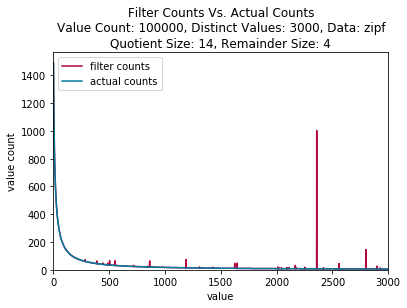

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.3744949
Mean Squared Error: 102.375271833
Correct 98.86321% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


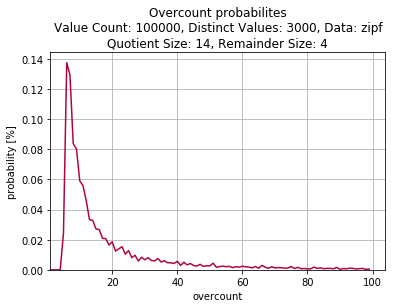

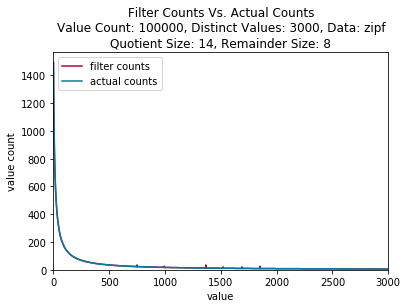

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0266032666667
Mean Squared Error: 7.12120846667
Correct 99.9251066667% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


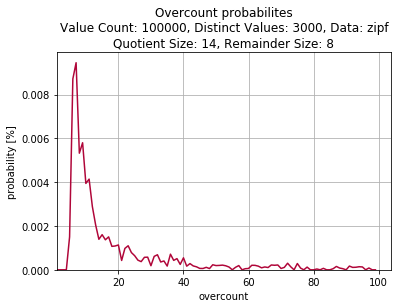

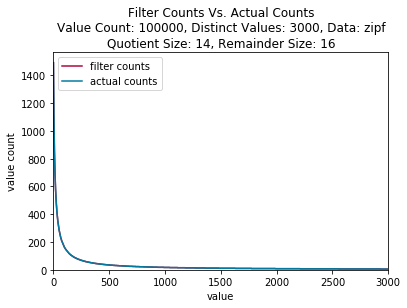

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 5.09666666667e-05
Mean Squared Error: 0.00201883333333
Correct 99.9997666667% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


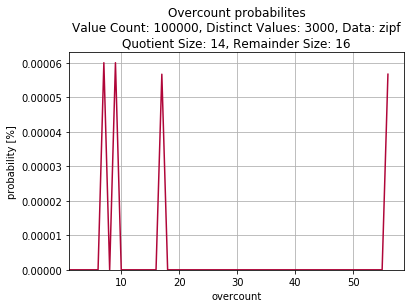

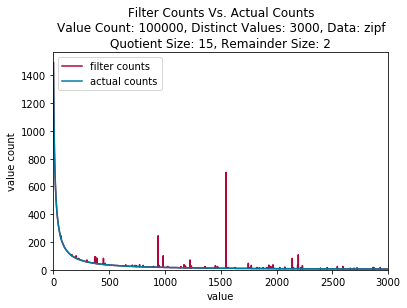

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.738482866667
Mean Squared Error: 202.3883158
Correct 97.7376466667% of the time
Filter Size [kB]: 16.384
Bits per Value: 1.31072
Column Size [kB](uint16_t): 200.0


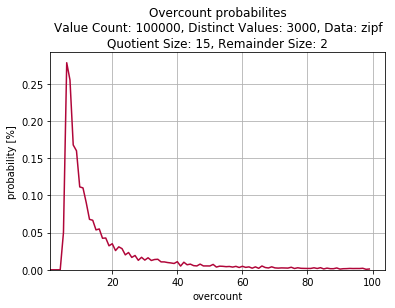

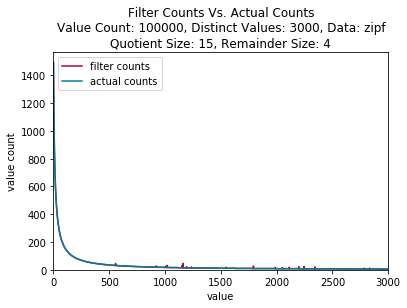

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.1893097
Mean Squared Error: 52.7160290333
Correct 99.4336933333% of the time
Filter Size [kB]: 24.576
Bits per Value: 1.96608
Column Size [kB](uint16_t): 200.0


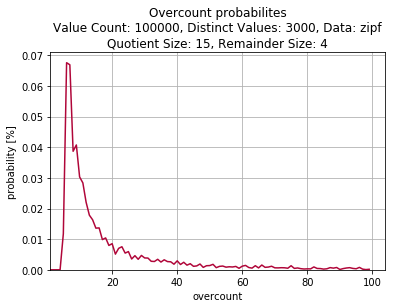

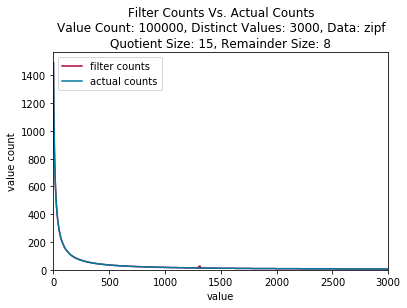

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0129756666667
Mean Squared Error: 3.53587086667
Correct 99.9632533333% of the time
Filter Size [kB]: 40.96
Bits per Value: 3.2768
Column Size [kB](uint16_t): 200.0


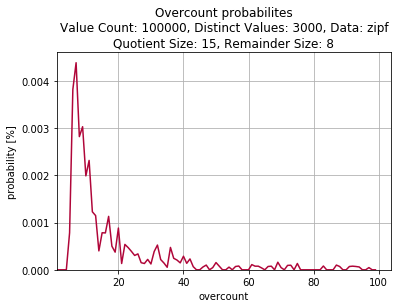

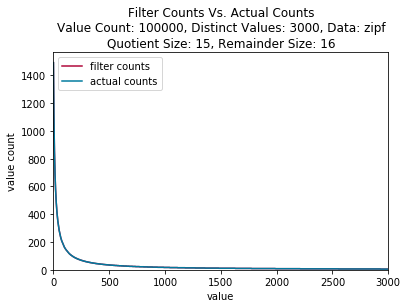

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 4.71e-05
Mean Squared Error: 0.00160983333333
Correct 99.99972% of the time
Filter Size [kB]: 73.728
Bits per Value: 5.89824
Column Size [kB](uint16_t): 200.0


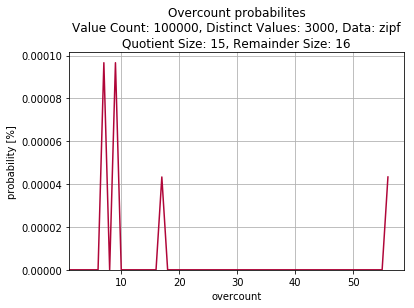

In [5]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14, 15]
data = "zipf"
distinct_values = 3000

for quotient_size in quotient_sizes:
    for remainder_size in remainder_sizes:
        evaluate(quotient_size, remainder_size, data, distinct_values)
        misestimation_evaluation(quotient_size, remainder_size, data, distinct_values)

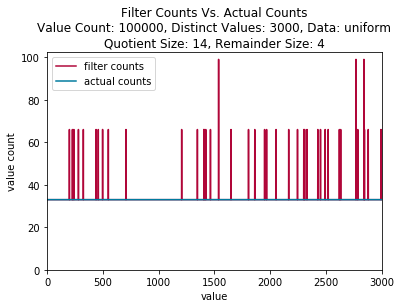

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.376475
Mean Squared Error: 12.5722146
Correct 98.8659866667% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


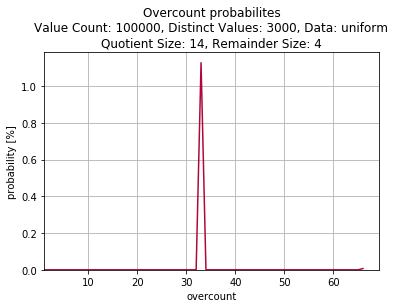

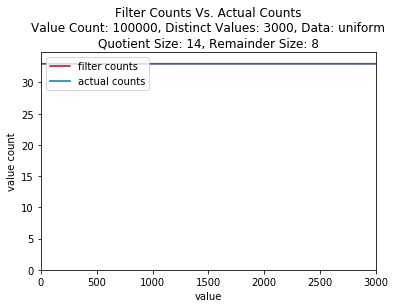

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0250602
Mean Squared Error: 0.8269866
Correct 99.92406% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


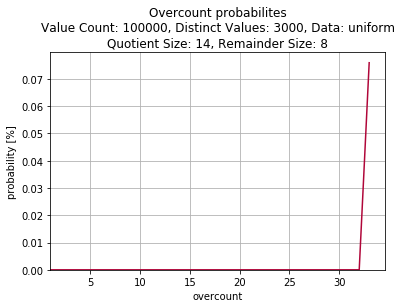

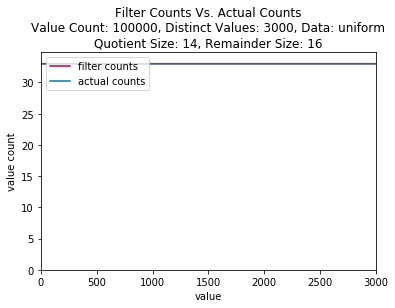

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 9.68e-05
Mean Squared Error: 0.0031944
Correct 99.9997066667% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


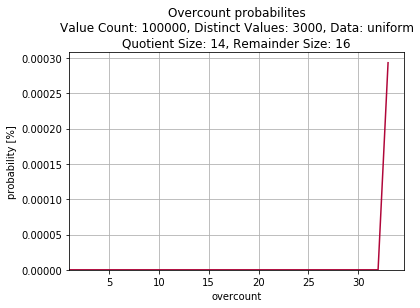

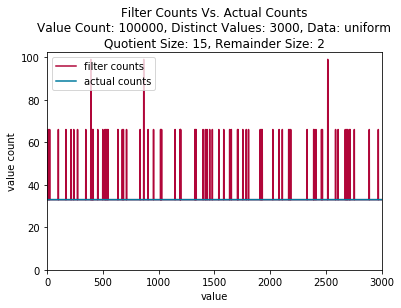

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.753115
Mean Squared Error: 25.3935924
Correct 97.7426633333% of the time
Filter Size [kB]: 16.384
Bits per Value: 1.31072
Column Size [kB](uint16_t): 200.0


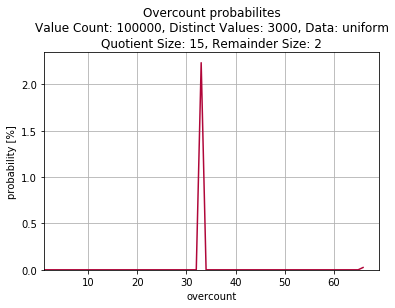

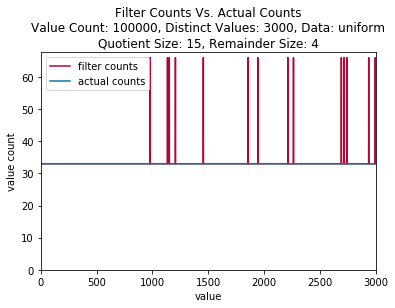

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.1880186
Mean Squared Error: 6.2671224
Correct 99.4331166667% of the time
Filter Size [kB]: 24.576
Bits per Value: 1.96608
Column Size [kB](uint16_t): 200.0


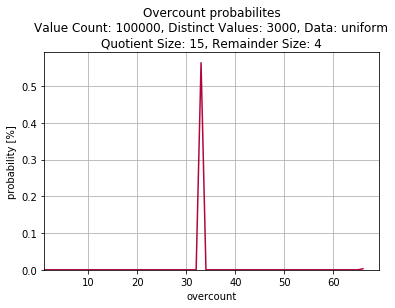

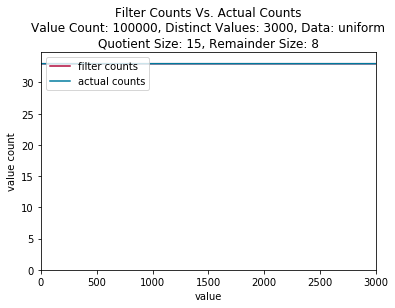

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0121286
Mean Squared Error: 0.4002438
Correct 99.9632466667% of the time
Filter Size [kB]: 40.96
Bits per Value: 3.2768
Column Size [kB](uint16_t): 200.0


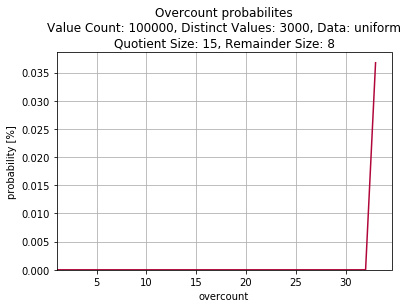

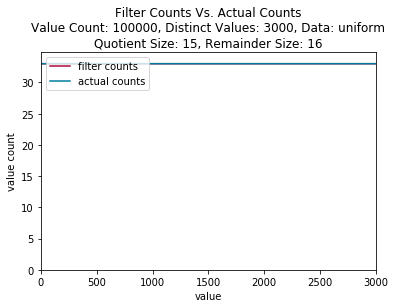

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 7.48e-05
Mean Squared Error: 0.0024684
Correct 99.9997733333% of the time
Filter Size [kB]: 73.728
Bits per Value: 5.89824
Column Size [kB](uint16_t): 200.0


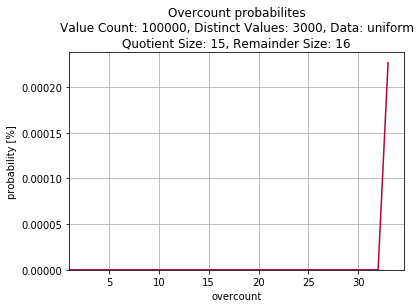

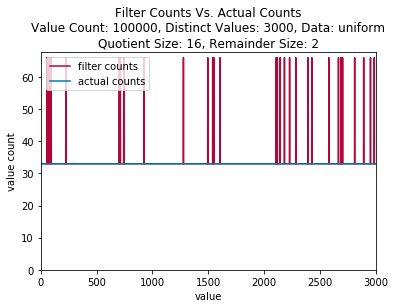

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.3766202
Mean Squared Error: 12.5628492
Correct 98.8648966667% of the time
Filter Size [kB]: 32.768
Bits per Value: 2.62144
Column Size [kB](uint16_t): 200.0


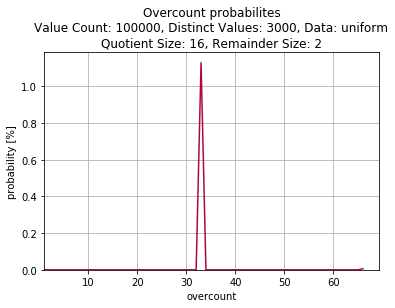

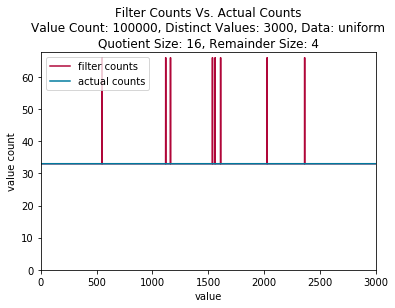

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0956472
Mean Squared Error: 3.1650696
Correct 99.71056% of the time
Filter Size [kB]: 49.152
Bits per Value: 3.93216
Column Size [kB](uint16_t): 200.0


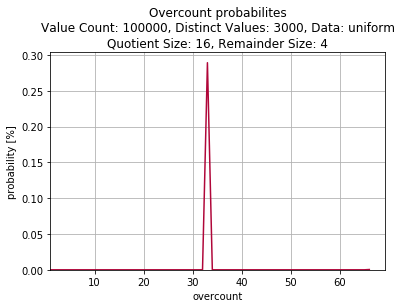

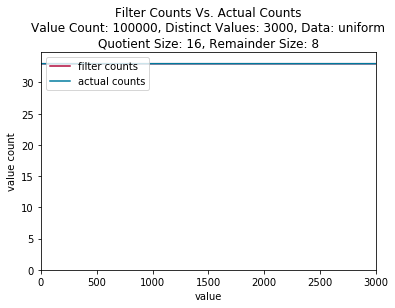

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0060302
Mean Squared Error: 0.1989966
Correct 99.9817266667% of the time
Filter Size [kB]: 81.92
Bits per Value: 6.5536
Column Size [kB](uint16_t): 200.0


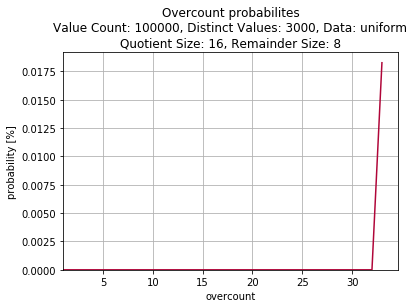

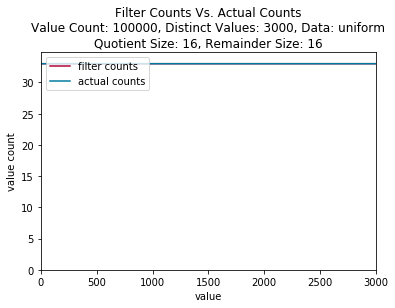

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 8.58e-05
Mean Squared Error: 0.0028314
Correct 99.99974% of the time
Filter Size [kB]: 147.456
Bits per Value: 11.79648
Column Size [kB](uint16_t): 200.0


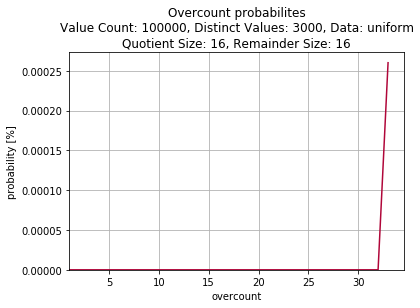

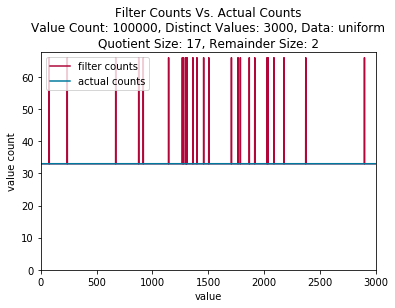

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.1871254
Mean Squared Error: 6.2365578
Correct 99.4357733333% of the time
Filter Size [kB]: 65.536
Bits per Value: 5.24288
Column Size [kB](uint16_t): 200.0


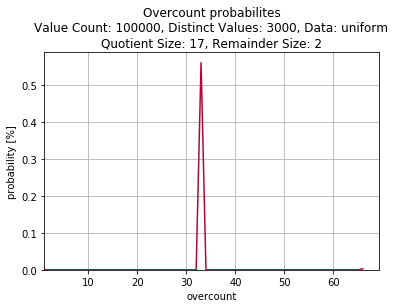

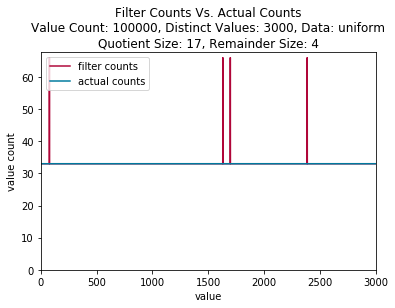

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0491018
Mean Squared Error: 1.6236264
Correct 99.8513566667% of the time
Filter Size [kB]: 98.304
Bits per Value: 7.86432
Column Size [kB](uint16_t): 200.0


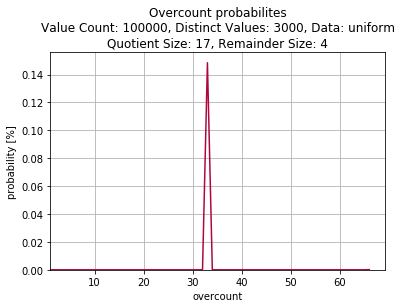

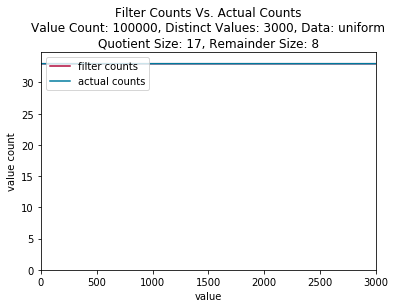

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0029106
Mean Squared Error: 0.0960498
Correct 99.99118% of the time
Filter Size [kB]: 163.84
Bits per Value: 13.1072
Column Size [kB](uint16_t): 200.0


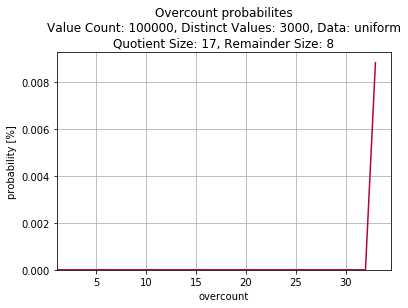

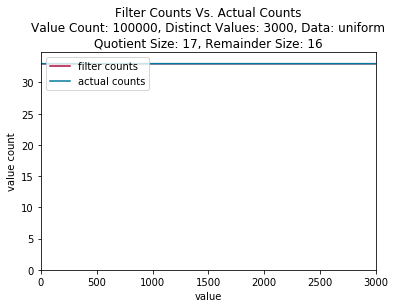

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 9.46e-05
Mean Squared Error: 0.0031218
Correct 99.9997133333% of the time
Filter Size [kB]: 294.912
Bits per Value: 23.59296
Column Size [kB](uint16_t): 200.0


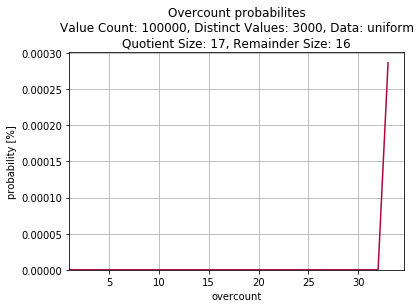

In [6]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [14, 15, 16, 17]

for quotient_size in quotient_sizes:
    for remainder_size in remainder_sizes:
        evaluate(quotient_size, remainder_size, "uniform", 3000)
        misestimation_evaluation(quotient_size, remainder_size, "uniform", 3000)

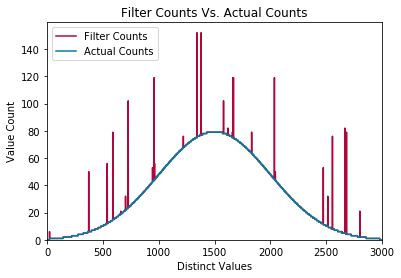

Sample Size: 30000000
One off error probability: 0.000903266666667
Mean Error: 0.376548133333
Mean Squared Error: 21.4181680667
Correct 98.8812866667% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


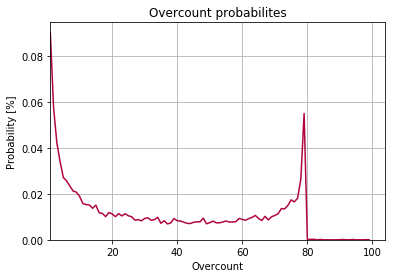

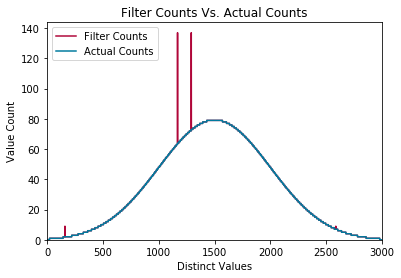

Sample Size: 30000000
One off error probability: 6.58333333333e-05
Mean Error: 0.0245600333333
Mean Squared Error: 1.39485023333
Correct 99.9250133333% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


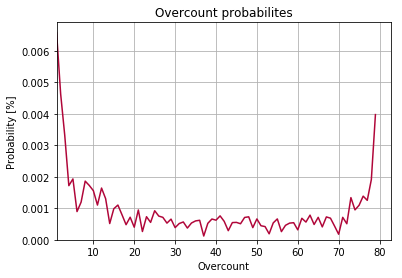

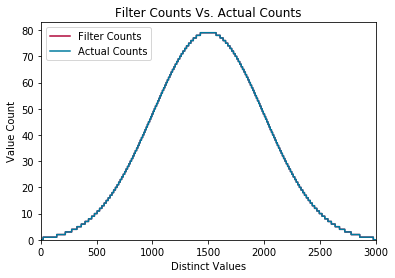

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 6e-05
Mean Squared Error: 0.002671
Correct 99.9998% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


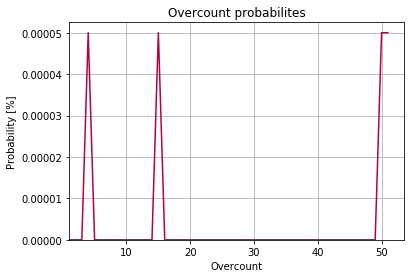

In [15]:
distinct_values = 3000
data = "normal"
evaluate(14, 4, data, distinct_values)
misestimation_evaluation(14, 4, data, distinct_values)
evaluate(14, 8, data, distinct_values)
misestimation_evaluation(14, 8, data, distinct_values)
evaluate(14, 16, data, distinct_values)
misestimation_evaluation(14, 16, data, distinct_values)

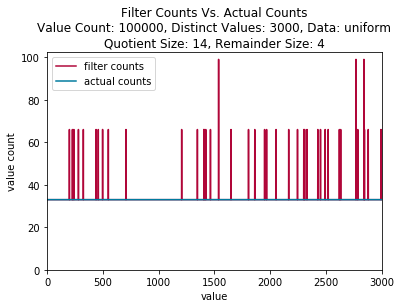

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.376475
Mean Squared Error: 12.5722146
Correct 98.8659866667% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


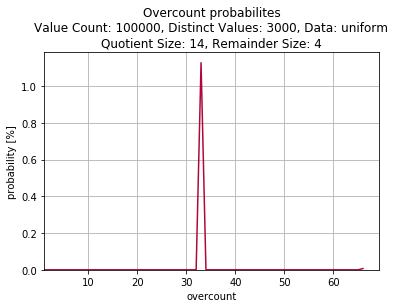

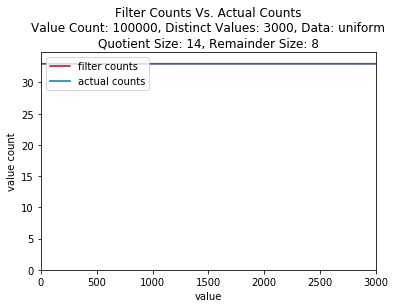

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0250602
Mean Squared Error: 0.8269866
Correct 99.92406% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


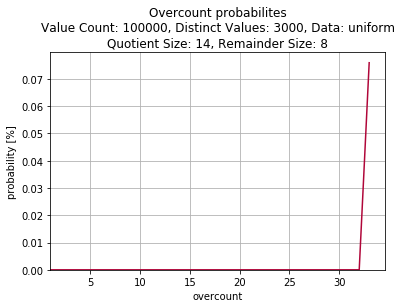

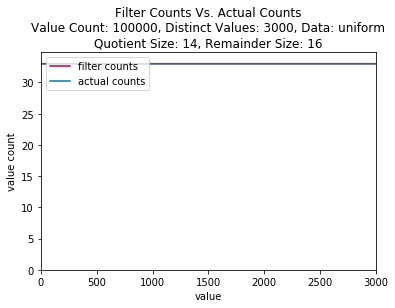

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 9.68e-05
Mean Squared Error: 0.0031944
Correct 99.9997066667% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


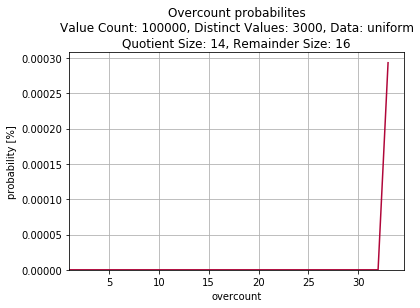

In [8]:
data = "uniform"
distinct_values = 3000

evaluate(14, 4, data, distinct_values)
misestimation_evaluation(14, 4, data, distinct_values)
evaluate(14, 8, data, distinct_values)
misestimation_evaluation(14, 8, data, distinct_values)
evaluate(14, 16, data, distinct_values)
misestimation_evaluation(14, 16, data, distinct_values)